In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from time import time

import numpy as np
import pandas as pd
import xarray as xr
from sklearn.linear_model import LinearRegression
from scipy import signal
import xrscipy.signal as dsp

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray

import gsw

from niwtools.tools import *
from niwtools.qc import *
from epsilon_tools import *

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

purp = pd.read_pickle('../data/purp_colormap.pkl')
# set up figure params
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1.3)
mpl.rc('figure', dpi=100, figsize=[12, 6])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

xr.set_options(display_style="text", display_width=100,warn_for_unclosed_files=True);

In [92]:
raw = xr.open_dataset('../data/raw_temp.nc')
raw = raw.drop(['lon','lat','pressure'])

## Find b'

In [93]:
raw['b_prime'] = raw.n2.rolling(time=18,center=True).mean()*raw.eta

(-200, 0)

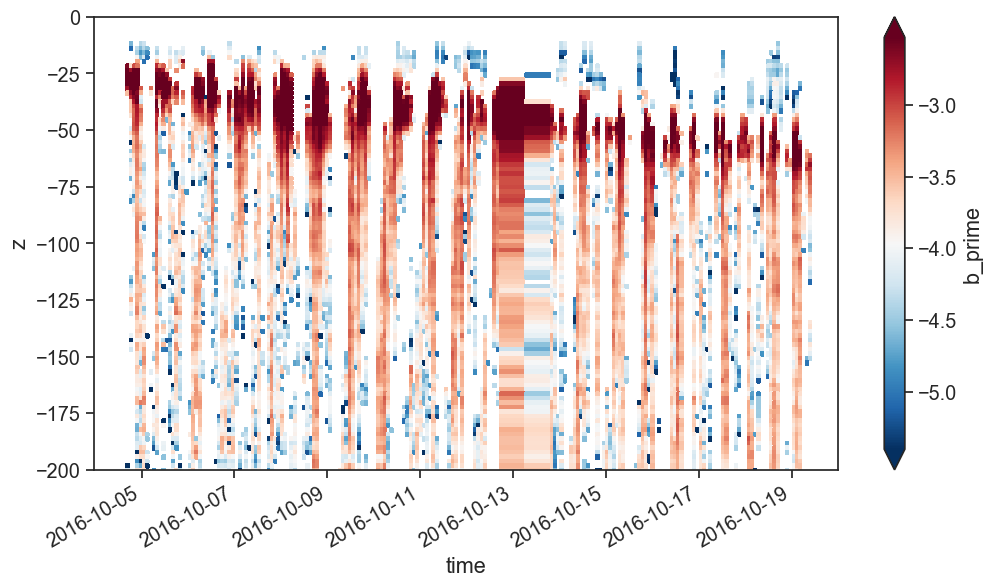

In [94]:
raw.b_prime.pipe(np.log10).plot(robust=True, cmap='RdBu_r')
plt.ylim(-200,0)

## Compute p'

$
p'(z) = \int_z^0 b'dz' - \frac{1}{H}\int_{-H}^0  \int_{z}^0 b'dz'dz
$

In [133]:
tliste=[]
for ti, t in enumerate(raw.time):
    temp = raw.isel(time=ti)
    
    liste=[]
    for zi, z in enumerate( temp.z):
        if temp.b_prime.isel(z=zi).notnull():
            term_a = integral( temp.b_prime, z, 0)
            term_a['z'] = z
            liste.append(term_a)
        else:
            liste.append( np.nan)

    cleanedList = [x for x in liste if type(x)!=float]
    
    if cleanedList:
        new = xr.concat(cleanedList, dim='z')
#         new = new - new.integrate('z')/new.z.max() 

        tliste.append(new)
    
pprime = xr.concat(tliste, dim='time')

In [135]:
tliste=[]
for ti, t in enumerate(pprime.time):
    temp = pprime.isel(time=ti)
    
    term_b = -integral( temp, temp.z.min(), 0)/ temp.z.min()
    tliste.append(term_b)
    
pprime_b = xr.concat(tliste, dim='time')

In [137]:
prime0 = pprime - pprime_b

(-200, 0)

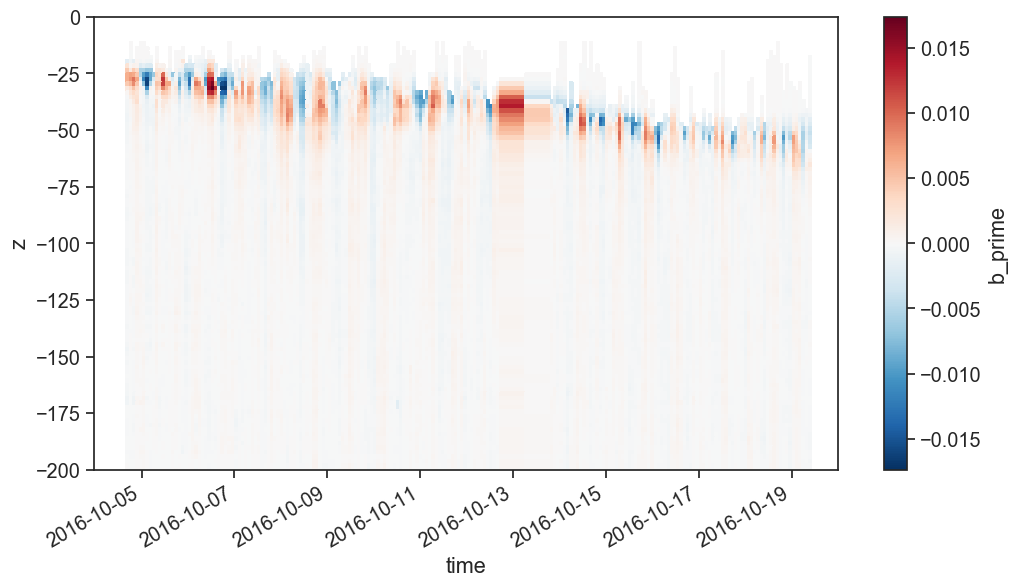

In [146]:
raw.b_prime.plot()
plt.ylim(-200,0)

(-200, 0)

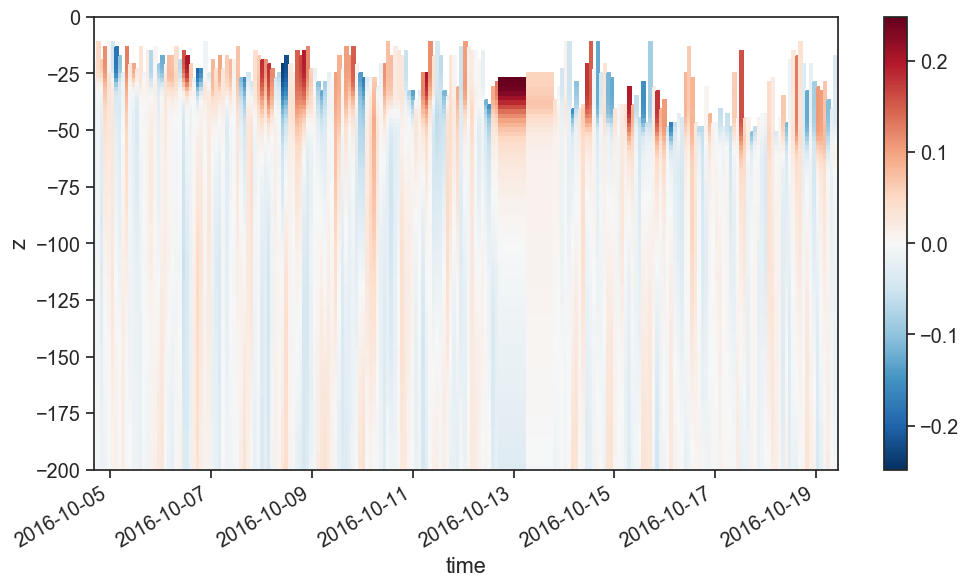

In [142]:
prime0.transpose().plot()
plt.ylim(-200,0)

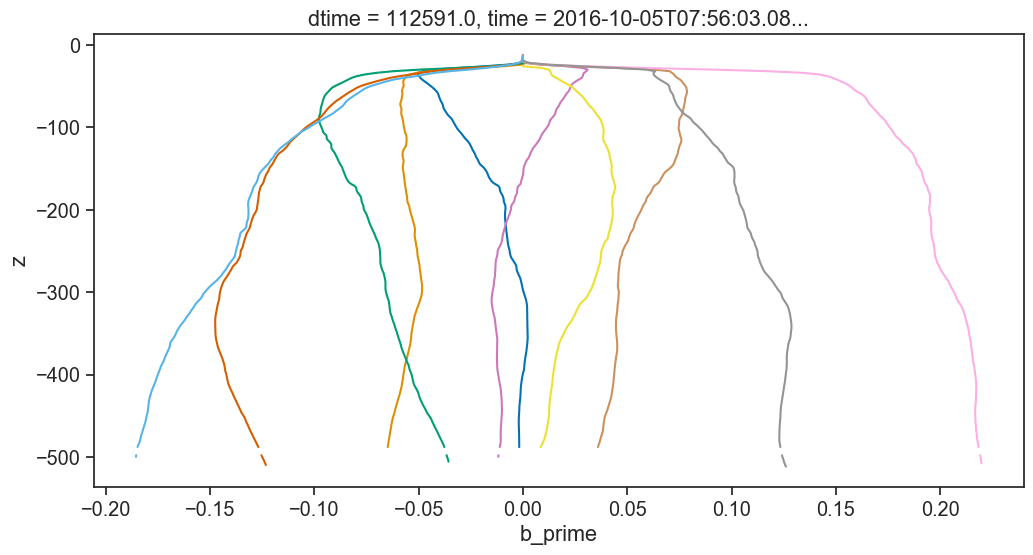

In [143]:
for i in range(10):
    pprime.isel(time=i).plot(y='z')